<a href="https://colab.research.google.com/github/Armelle-h/ML_frames_and_videos/blob/main/NeuralNetwork.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import sys
sys.path.insert(0,'/content/drive/MyDrive/ML_project_frames_and_videos') #for future uses, replace with the path of the working folder

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from functools import partial
from torch.utils.data import DataLoader
%matplotlib inline
%load_ext autoreload
%autoreload 2
! pip install ftfy #needed for CLIP to run
! pip install torchmetrics
import torchmetrics

import os
import math

from Pair_Frames import Pair_Frames

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 53 kB 1.7 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 512 kB 9.0 MB/s 


In [ ]:
class Model_Similarity_Pair_Frames(nn.Module):
  def __init__(self):
    super().__init__()
    #Remplir les fonctions d'activations ici nn.Relu, nn.Linear
    self.input_layer = torch.nn.Linear(1024, 250) #1024, the size of 2 feature vectors concatenated, 250 the number of neurons in our hidden layers
    self.input_phi = torch.nn.ReLU()
    self.layer1 = torch.nn.Linear(250, 250) #constructed as "(number of in-edges, number of out-edges)"
    self.phi1 = torch.nn.ReLU()
    self.layer2 = torch.nn.Linear(250, 250)
    self.phi2 = torch.nn.ReLU()
    self.output_layer = torch.nn.Linear(250, 2) #our model outputs pair of values coresponding to "(P['not the same video], P['same video'])"

  def forward(self,PF):
    """PF a pair of frames"""
    #put the forward pass of the neural network using the activations functions
    PF = self.input_layer(PF)
    PF = self.input_phi(PF) #activation function on first layer
    PF = self.layer1(PF)
    PF = self.phi1(PF)
    PF = self.layer2(PF)
    PF = self.phi2(PF)
    PF = self.output_layer(PF)
    return PF

In [ ]:

def train_epoch(model, device, train_loader, optimizer, epoch, criterion): #e.g criterion=nn.MSELoss()
    model.train()  # Important set model to train mode (affects dropout, batch norm etc)

    loss_history = []
    accuracy_history = []
    for batch_idx, (feature1, feature2, label) in enumerate(train_loader):
      feature1 = feature1.to(device).float() #change to device selected
      feature2 = feature2.to(device).float()
      target =label.to(device)
      if feature1.shape[0]==1: #there was an issue if the tensor had shape (1,n)
        f1=torch.flatten(feature1, 0)
        f2=torch.flatten(feature2, 0)
        data = torch.cat([f1, f2])
        output = model(data)
        output=output.reshape([1, output.shape[0]])
      else:
        data=torch.cat([feature1, feature2], dim=1)
        output = model(data)
      #optimisation
      optimizer.zero_grad()
      output = model(data)
      loss = criterion(output, target)
      loss.backward()
      optimizer.step()

      pred = output.argmax(dim=1, keepdim=True) #idea is that our model outputs a pair of proba. With this command, we keep only the index
      #indicating where the highest value is and we do this column-wise
      correct = pred.eq(target.view_as(pred)).sum().item() #this counts the number of good answers we had when comparing to our target.
      #the target has value 0 if "data[0]" belongs to two different videos and value 1 if it belongs to the same

      loss_history.append(loss.item())
      accuracy_history.append(correct / len(data))

      print(
          f"Train Epoch: {epoch}-{batch_idx} batch_loss={loss.item()/len(data):0.2e} batch_acc={correct/len(data):0.3f}"
      )

    return loss_history, accuracy_history


@torch.no_grad() #'reset' gradients
def validate(model, device, val_loader, criterion):
    model.eval()  # Important set model to eval mode (affects dropout, batch norm etc)
    test_loss = 0
    correct = 0
    for batch_idx, (feature1, feature2, label) in enumerate(val_loader):
      feature1 = feature1.to(device).float() #change to device selected
      feature2 = feature2.to(device).float()
      target =label.to(device)
      if feature1.shape[0]==1: #there was an issue if the tensor had shape (1,n)
        f1=torch.flatten(feature1, 0)
        f2=torch.flatten(feature2, 0)
        data = torch.cat([f1, f2])
        output = model(data)
        output=output.reshape([1, output.shape[0]])
      else:
        data=torch.cat([feature1, feature2], dim=1)
        output = model(data)
      test_loss += criterion(output, target).item() * len(data) #weighted sum

      pred = output.argmax(dim=1, keepdim=True) #idea is that our model output a pair of proba. With this command, we keep only the index
        #indicating where the highest value is and we do this column-wise

      correct +=pred.eq(target.view_as(pred)).sum().item() #this counts the number of good answers we had when comparing to our target and adds
        #them to the number of already well predicted pair of frames.
        #the target has value 0 if "data[0]" belongs to two different videos and value 1 if it belongs to the same

    test_loss /= len(val_loader.dataset) #we renormalize as we did a weighted sum

    print(
        "Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)".format(
            test_loss,
            correct,
            len(val_loader.dataset),
            100.0 * correct / len(val_loader.dataset),
        )
    )
    return test_loss, correct / len(val_loader.dataset)


@torch.no_grad()
def get_predictions(model, device, val_loader, criterion, num=None):
    model.eval()
    points = []
    for batch_idx, (feature1, feature2, label) in enumerate(val_loader):
      feature1 = feature1.to(device).float() #change to device selected
      feature2 = feature2.to(device).float()
      target =label.to(device)
      if feature1.shape[0]==1: #there was an issue if the tensor had shape (1,n)
        f1=torch.flatten(feature1, 0)
        f2=torch.flatten(feature2, 0)
        data = torch.cat([f1, f2])
        output = model(data)
        output.reshape([1, output.shape[0]])
      else:
        data=torch.cat([feature1, feature2], dim=1)
        output = model(data)
      loss = criterion(output, target)
      pred = output.argmax(dim=1, keepdim=True)

      data = np.split(data.cpu().numpy(), len(data))
      loss = np.split(loss.cpu().numpy(), len(data))
      pred = np.split(pred.cpu().numpy(), len(data))
      target = np.split(target.cpu().numpy(), len(data))
      points.extend(zip(data, loss, pred, target))

      if num is not None and len(points) > num:
          break

    return points


def run_pair_frames_training(video_dir, num_epochs, lr, batch_size, device="cpu"):
    '''
  num_epochs= nb of transits through the algorithm, how many "forward propagation-backpropagation" ping pong exchange are we doing | e.g. 2
  lr= learning rate, the step size| e.g. 5e-3
  batch_size=int, size of the batch of our datapoints
  model=string, the name we want to save our model under. By default the current datetime.
    '''

    # ===== Data Loading =====
    length=10000 #length can be tuned
    length_train=math.floor(0.7*length)
    length_val=math.floor(0.15*length)
    train_set = Pair_Frames(video_dir, train=0, length=length_train, device=device)
    val_set = Pair_Frames(video_dir, train=1, length=length_val, device=device)

    # The dataloaders can run in separate threads and handle the actual data
    # reading, augmenting and forming mini-batches
    train_loader = torch.utils.data.DataLoader(
        train_set,
        batch_size=batch_size,
        shuffle=True,  # Can be important for training
        pin_memory=False, #used to be torch.cuda.is_available(), keep False, else error says only dense cuda tensor can be pinned
        drop_last=True,
        num_workers=0, #for multiprocess data loading we can't do that on gpus (google colab restriction) so set to 0
    )
    val_loader = torch.utils.data.DataLoader(
        val_set,
        batch_size=batch_size,
    )

    # ===== Model, Optimizer and Criterion =====
    model = Model_Similarity_Pair_Frames()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr) # choosing Adam
    criterion = torch.nn.functional.cross_entropy # choosing this one as we have a classification problem

    # ===== Train Model =====
    train_loss_history = []
    train_acc_history = []
    val_loss_history = []
    val_acc_history = []
    for epoch in range(1, num_epochs + 1):
        train_loss, train_acc = train_epoch(
            model, device, train_loader, optimizer, epoch, criterion
        )
        train_loss_history.extend(train_loss)
        train_acc_history.extend(train_acc)

        val_loss, val_acc = validate(model, device, val_loader, criterion)
        val_loss_history.append(val_loss)
        val_acc_history.append(val_acc)

    # ===== Plot training curves =====
    n_train = len(train_acc_history)
    t_train = num_epochs * np.arange(n_train) / n_train
    t_val = np.arange(1, num_epochs + 1)
    plt.figure()
    plt.plot(t_train, train_acc_history, label="Train")
    plt.plot(t_val, val_acc_history, label="Val")
    plt.legend()
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")

    plt.figure()
    plt.plot(t_train, train_loss_history, label="Train")
    plt.plot(t_val, val_loss_history, label="Val")
    plt.legend()
    plt.xlabel("Epoch")
    plt.ylabel("Loss")

    #saves the trained model parameters in the folder 'trained_model' under the name 'name'
    name=f'{num_epochs}_{length}_{lr}_{batch_size}_model.pt'
    torch.save({
            'epoch': num_epochs,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': criterion,
            }, os.path.join('/content/drive/MyDrive/ML_project_frames_and_videos/trained_models', name)) #Replace with the path to a folder to save the model
    #saves also weights of the optimizer and the criterion, might not use them but good to have just in case
    #The point of saving model.state_dict() is that we don't save the entire model but only the learned parameters.
    #If we had saved the entire model, then we would've been constrained to the classes we used and the exact directory structure.

Train Epoch: 1-0 batch_loss=5.43e-03 batch_acc=0.492
Train Epoch: 1-1 batch_loss=5.37e-03 batch_acc=0.531
Train Epoch: 1-2 batch_loss=5.57e-03 batch_acc=0.523
Train Epoch: 1-3 batch_loss=5.08e-03 batch_acc=0.562
Train Epoch: 1-4 batch_loss=4.80e-03 batch_acc=0.531
Train Epoch: 1-5 batch_loss=4.31e-03 batch_acc=0.805
Train Epoch: 1-6 batch_loss=4.13e-03 batch_acc=0.758
Train Epoch: 1-7 batch_loss=4.04e-03 batch_acc=0.773
Train Epoch: 1-8 batch_loss=4.16e-03 batch_acc=0.758
Train Epoch: 1-9 batch_loss=4.53e-03 batch_acc=0.734
Train Epoch: 1-10 batch_loss=3.26e-03 batch_acc=0.820
Train Epoch: 1-11 batch_loss=4.07e-03 batch_acc=0.781
Train Epoch: 1-12 batch_loss=3.74e-03 batch_acc=0.773
Train Epoch: 1-13 batch_loss=4.77e-03 batch_acc=0.656
Train Epoch: 1-14 batch_loss=4.25e-03 batch_acc=0.742
Train Epoch: 1-15 batch_loss=3.97e-03 batch_acc=0.742
Train Epoch: 1-16 batch_loss=3.69e-03 batch_acc=0.781
Train Epoch: 1-17 batch_loss=3.55e-03 batch_acc=0.758
Train Epoch: 1-18 batch_loss=3.43e-03 

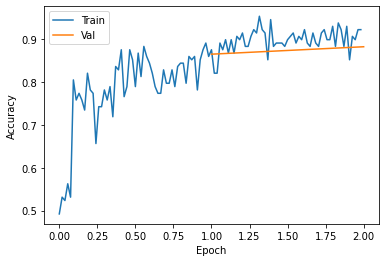

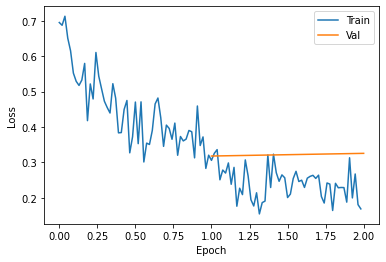

In [ ]:

lr = 5e-3
batch_size = 128
num_epochs = 2
video_dir='/content/drive/MyDrive/ML_project_frames_and_videos/DATA/videos' #Replace with a the path to the folder containing the videos
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

run_pair_frames_training(video_dir, num_epochs, lr, batch_size, device)

#next cell, how to load the trained model

In [ ]:
#to load a trained model:

#by default loads the last model
name=os.listdir('/content/drive/MyDrive/ML_project_frames_and_videos/trained_models')[-1] #The folder containing the trained model
lr = 5e-3
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Model_Similarity_Pair_Frames()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
checkpoint = torch.load(os.path.join('/content/drive/MyDrive/ML_project_frames_and_videos/trained_models', name), map_location=device) #The folder containing the trained model
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
num_epochs = checkpoint['epoch']
criterion = checkpoint['loss']

print(f"Previously trained for {num_epochs} number of epochs and with the loss function {criterion}")

Previously trained for 2 number of epochs and with the loss function <function cross_entropy at 0x7fd69fe12d30>
